## Assignment 3 - Logistic Regression

## Import the Necessary PySpark and MlLib libraries

In [1]:
from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext,SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Build a spark session and Load the Dataset

In [7]:
#Initializing the SparkSession
spark=SparkSession.builder.appName("LogisticRegression").getOrCreate()

#loading the dataset
customer_df=spark.read.option("header",'True').option("inferSchema","True")\
    .option('delimiter',',').csv("customer_churn.csv")
#print the no.of.rows and columns
print("There are",customer_df.count(),"rows",len(customer_df.columns),"columns in the data.")

There are 900 rows 10 columns in the data.


Display the Dataframe

In [8]:
customer_df.describe().show()

+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|        Names|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|            Location|             Company|              Churn|
+-------+-------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|          900|              900|              900|               900|              900|               900|                 900|                 900|                900|
|   mean|         NULL|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|                NULL|                NULL|0.16666666666666666|
| stddev|         NULL|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.764835592035

Print the Schema in tree format

In [9]:
customer_df.cache()
customer_df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



Descriptive  Analysis

In [10]:
numeric_features = [t[0] for t in customer_df.dtypes if t[1]=='double']
customer_df.describe().toPandas().transpose() 

,0,1,2,3,4
summary,count,mean,stddev,min,max
Names,900,None,None,Aaron King,Zachary Walsh
Age,900,41.81666666666667,6.127560416916251,22.0,65.0
Total_Purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
Account_Manager,900,0.4811111111111111,0.4999208935073339,0,1
Years,900,5.27315555555555,1.274449013194616,1.0,9.15
Num_Sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
Location,900,None,None,"00103 Jeffrey Crest Apt. 205 Padillaville, IA ...",Unit 9800 Box 2878 DPO AA 75157
Company,900,None,None,Abbott-Thompson,"Zuniga, Clark and Shaffer"
Churn,900,0.16666666666666666,0.3728852122772358,0,1


Target Variable Distribution

In [11]:
customer_df.groupby("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [13]:
#convert the data into pandas data 
import seaborn as sns

df=customer_df.toPandas()
df

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1
...,...,...,...,...,...,...,...,...,...,...
895,Paul Miller,42.0,12800.82,1,3.62,8.0,2007-12-01 13:29:34,"9316 Julian Fort Suite 328 North Leslie, ME 43961",Evans-Lucero,0
896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,2008-12-28 15:23:58,"8419 William Square Apt. 695 Martinville, RI 3...",Perry and Sons,0
897,Ana Smith,45.0,12056.18,0,5.46,4.0,2014-06-20 05:10:09,Unit 8633 Box 8738 DPO AA 14126-5026,Schneider-Smith,0
898,Justin Leonard,51.0,6517.93,1,5.47,10.0,2012-05-30 00:15:43,"49800 Torres Ways Suite 886 West Bradleybury, ...",Robles-Abbott,0


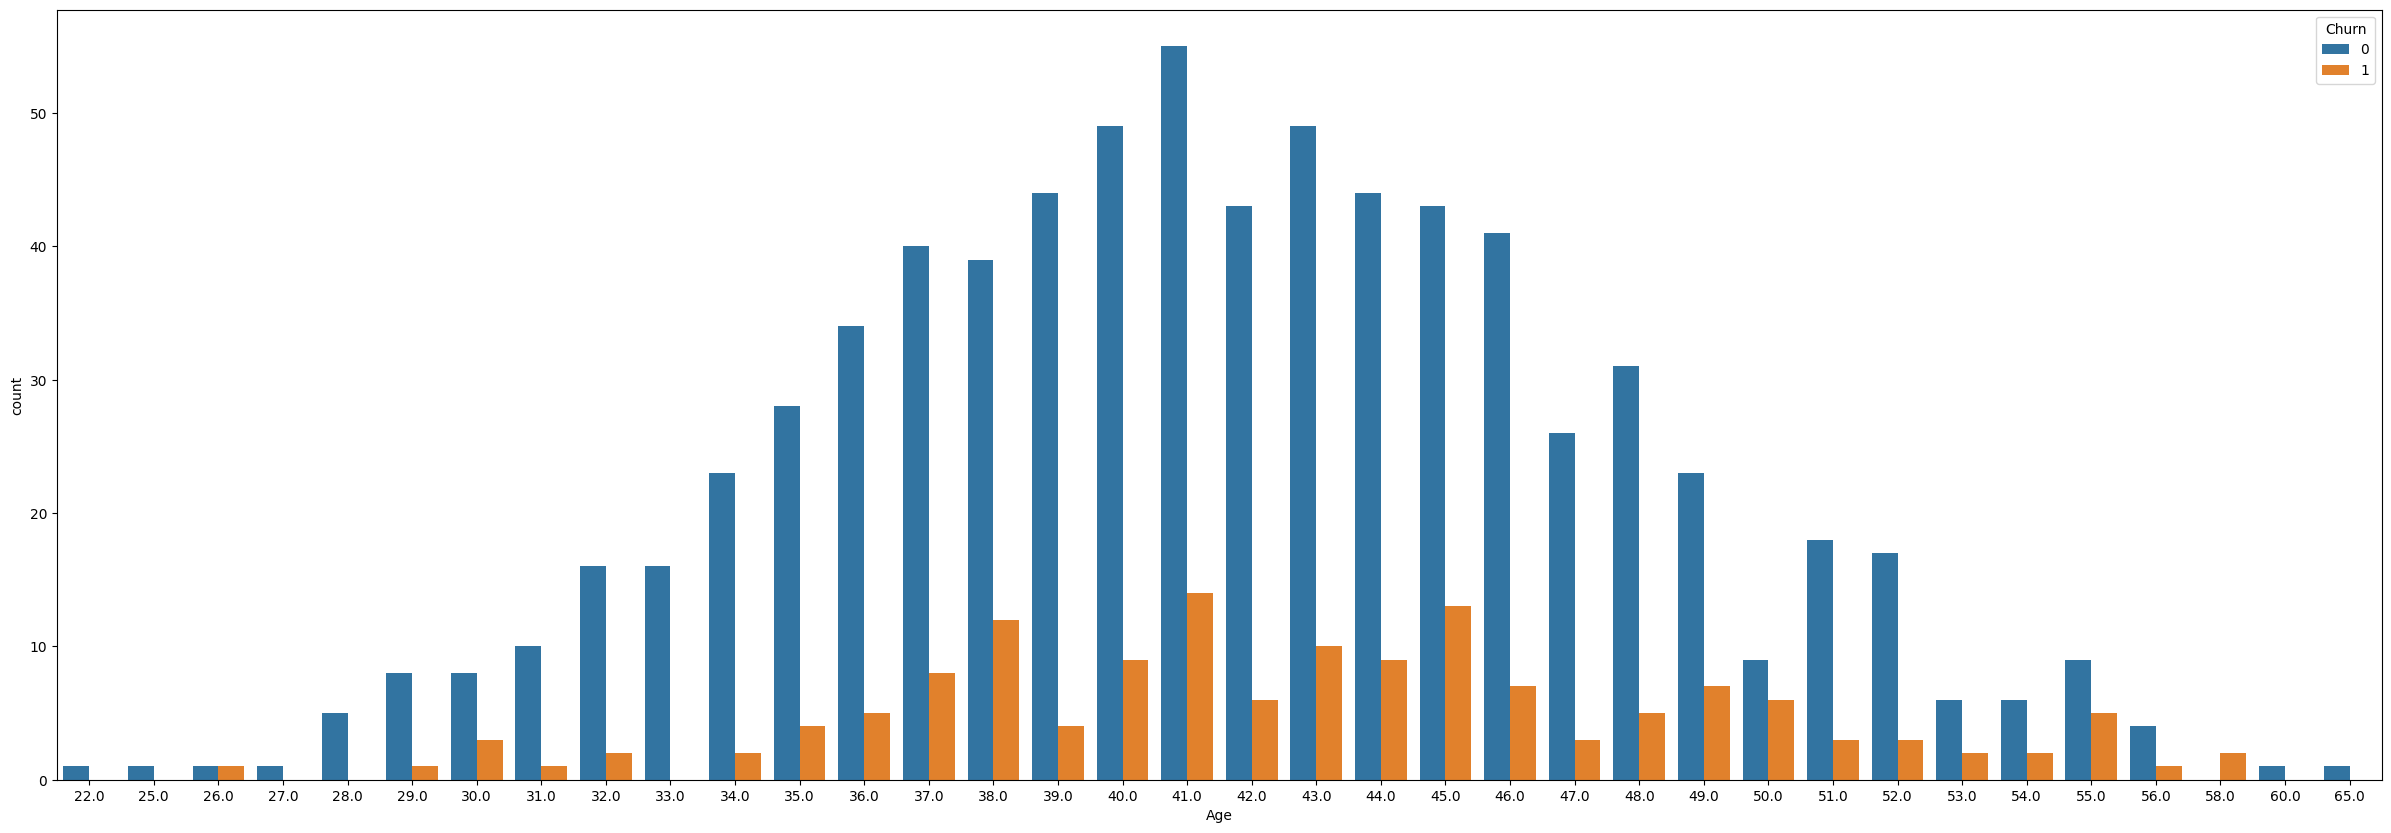

In [14]:
#Analyzing the label with the feature Age
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(30,10))
sns.countplot(data=df, x='Age',hue='Churn')
plt.show()

## Data Preprocessing
#### Assuming 'Churn' is the target variable

In [15]:
#import  VectorAssembler 
from pyspark.ml.feature import VectorAssembler, StandardScaler

input_cols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites']
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df_assembled = assembler.transform(customer_df)

In [21]:
final_customer_df = df_assembled.select('features','Churn')

## Split the Data into training and testing

In [22]:
train_df, test_df = final_customer_df.randomSplit([0.7,0.3],seed=42)

In [23]:
#Standardize the features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(train_df)
train_df_scaled = scaler_model.transform(train_df)
test_df_scaled = scaler_model.transform(test_df)

## Model Training

In [24]:
#Create and Train the Logistic Regression model

lr=LogisticRegression(labelCol='Churn')
lr_model= lr.fit(train_df_scaled)
training_sum = lr_model.summary

### Make predictions on the test set

In [27]:

training_sum.predictions.describe().show()

+-------+------------------+-------------------+
|summary|             Churn|         prediction|
+-------+------------------+-------------------+
|  count|               667|                667|
|   mean|0.1634182908545727|0.12293853073463268|
| stddev|0.3700243606477147|0.32861306618408714|
|    min|               0.0|                0.0|
|    max|               1.0|                1.0|
+-------+------------------+-------------------+



In [26]:
#Evaluate the model

predictions_labels = lr_model.evaluate(test_df_scaled)

In [28]:
#Display Confusion Matrix
predictions_labels.predictions.show()

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|Churn|     scaled_features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|[26.0,8787.39,1.0...|    1|[4.31436398285103...|[0.79106248132020...|[0.68805942038441...|       0.0|
|[28.0,9090.43,1.0...|    0|[4.64623813537803...|[1.61026688857555...|[0.83344843709585...|       0.0|
|[28.0,11204.23,0....|    0|[4.64623813537803...|[1.97148345642762...|[0.87777036176974...|       0.0|
|[28.0,11245.38,0....|    0|[4.64623813537803...|[3.75331012854098...|[0.97709682330471...|       0.0|
|[29.0,9617.59,0.0...|    0|[4.81217521164153...|[4.42202807822147...|[0.98813267415840...|       0.0|
|[29.0,10203.18,1....|    0|[4.81217521164153...|[3.71080419195967...|[0.97612605863733...|       0.0|
|[29.0,11274.46,1....|    0|[4.81217521164153...|[4.39058463869248...|[0.

## Using AUC

In [30]:
churn_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                           labelCol='Churn')

auc = churn_eval.evaluate(predictions_labels.predictions)
auc

0.7456808943089431